# Data Visualization Notebook

In this notebook, we will perform multiple plots to visualize our dataset distribution, and how it is distributed accross the nodes.

But first, some global imports:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.insert(0, '../modules')

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn

## Dataset

The dataset is a _skewed_ Gaussian distribution in 2D.

Here, we will create it, and present it:

In [2]:
from data import get_data
from graph import graph, model_lr
from topos import ring_topo

num_samples = 2000
nodes = 5

X, y = get_data(num_samples)
W = ring_topo(nodes)

model_kwargs = {"input_dim" : X.shape[1], "output_dim": y.shape[1]}
optimiser_kwargs = {"lr" : 0.01} # specify keyword args for model

graph_kwargs = {"model_kwargs": model_kwargs, #pass model kwargs
    "optimiser_kwargs" : optimiser_kwargs,
    "criteria" : nn.MSELoss, #specify loss function for each node
    "model" : model_lr, #specify model class handle
    "optimiser" : torch.optim.SGD, #specify global optimiser
    "batch_size" : 200 #specify batch size for each node
}

G = graph((X, y), W, iid=False, **graph_kwargs)

X, y = G.data

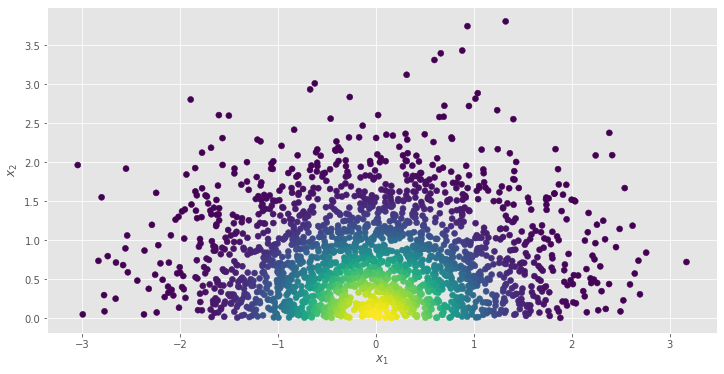

In [3]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

Now. we will show what every nodes receives.

Notice how the samples are non iid:

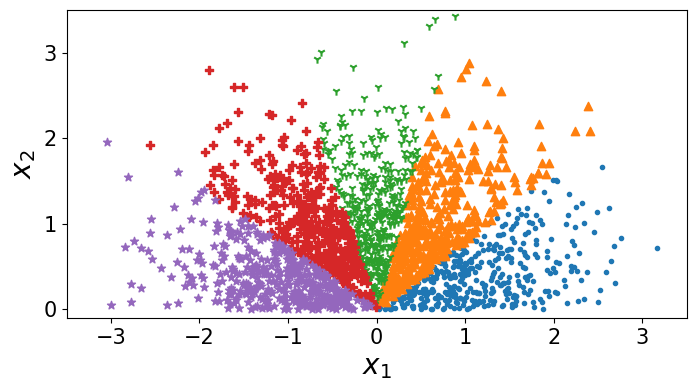

In [4]:
import itertools
import matplotlib.colors as mcolors

nodes = 5
N = X.shape[0] // nodes

colors = itertools.cycle(mcolors.TABLEAU_COLORS)
markers = itertools.cycle(['.', '^', '1', 'P', '*'])

plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(8, 4))
for i in range(nodes):
    plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1],
                c=next(colors), marker=next(markers))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-3.5, 3.5)
plt.ylim(-0.1, 3.5)
plt.show()

## Visualizing node weights

In this section we will see how the weights in the nodes converge to reduce the loss as they mix with other nodes' weights.

First, we load the data and create the graph:

In [5]:
from data import get_data
from graph import graph, model_lr
from topos import ring_topo, fc_topo

num_samples = 2000
nodes = 5

X, y = get_data(num_samples)

np.random.seed(0)
torch.manual_seed(0)

data = (X, y)

W_matrix = fc_topo(nodes)

model_kwargs = {"input_dim" : X.shape[1], "output_dim": y.shape[1]}
optimiser_kwargs = {"lr" : 0.01} # specify keyword args for model

graph_kwargs = {"model_kwargs": model_kwargs, #pass model kwargs
    "optimiser_kwargs" : optimiser_kwargs,
    "criteria" : nn.MSELoss, #specify loss function for each node
    "model" : model_lr, #specify model class handle
    "optimiser" : torch.optim.SGD, #specify global optimiser
    "batch_size" : 200 #specify batch size for each node
}

G = graph(data, W_matrix, iid=False, **graph_kwargs)

lr = 0.01
# define global optimizer
G.set_optimizer(torch.optim.SGD, lr=lr)

X, y = G.data

In [6]:
node_i = 1
node_ws = []
node_bs = []
num_iters = 5
for i in range(num_iters):
    with torch.no_grad():
        gen = G.nodes[node_i].model.parameters()
        node_ws += [next(gen).numpy().copy()]
        node_bs += [next(gen).numpy().copy()]
    G.run(mixing_steps=0,
          local_steps=8,
          iters=1)
node_ws = np.r_[node_ws].squeeze(1)
node_bs = np.r_[node_bs]

train loss : 0.3668635681271553
train loss : 0.3362771838903427
train loss : 0.3142214462161064
train loss : 0.29336963146924977
train loss : 0.2738993734121323


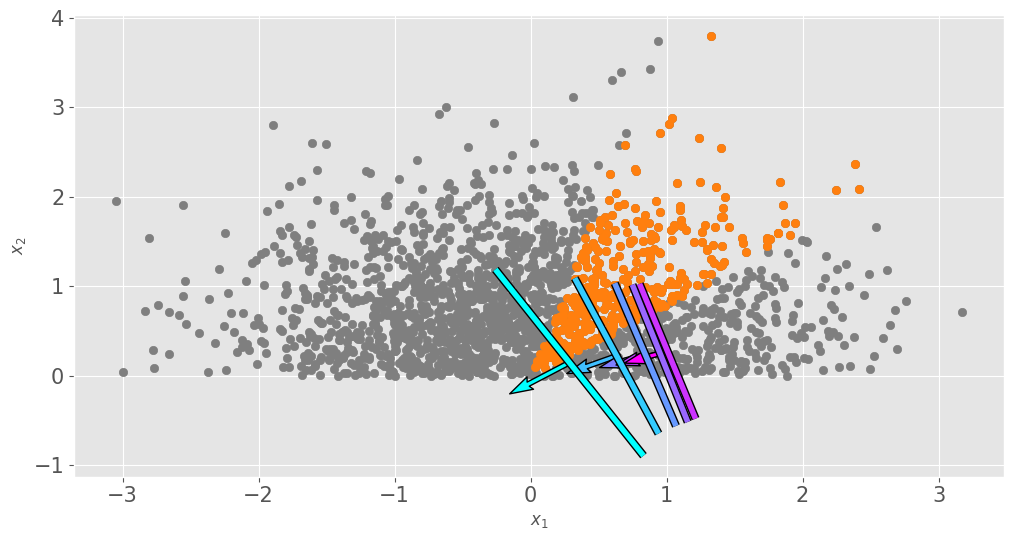

In [7]:
import matplotlib.colors as mcolors
from matplotlib import collections  as mc

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

N = X.shape[0] // nodes
idx = slice(node_i*N, (node_i+1)*N)
colors = list(mcolors.TABLEAU_COLORS)
ws_pos = -node_ws * node_bs / np.sum(node_ws**2, axis=1)[:, np.newaxis]

plt.scatter(X[:, 0], X[:, 1], c='tab:grey')
plt.scatter(X[idx, 0], X[idx, 1], c=colors[node_i])

# weight arrows
colors = np.arange(ws_pos.shape[0])
cmap = 'cool'


node_ws_perp = np.c_[-node_ws[:, 1], node_ws[:, 0]]
lines1 = ws_pos + node_ws_perp*2
lines2 = ws_pos - node_ws_perp*2
lines = np.empty((ws_pos.shape[0], 2, ws_pos.shape[1]))
lines[:, 0, :] = lines1
lines[:, 1, :] = lines2

cmap2 = matplotlib.cm.get_cmap(cmap)
colors2 = [cmap2(c/ws_pos.shape[0]) for c in colors]
lc1 = mc.LineCollection(lines, colors='k', lw=6)
lc2 = mc.LineCollection(lines, colors=colors2, lw=4)
plt.gca().add_collection(lc1)
plt.gca().add_collection(lc2)

plt.quiver(ws_pos[:, 0], ws_pos[:, 1], node_ws[:, 0], node_ws[:, 1],
           colors, cmap=cmap, ec='k', lw=1, width=0.005)

# plt.ylim(-0.1, None)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()